In [ ]:
# Cell 1: Importy
import sys
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_generation import generate_realistic_data
from feature_engineering import normalize_data
from model_training import train_model, evaluate_model, optimize_threshold
from visualization import (plot_distributions, plot_confusion_matrix, plot_roc_curve, plot_task2_cost, plot_correlation_matrix, plot_betas, plot_feature_impact)

In [2]:
# Cell 2: Generowanie danych
print("Generowanie danych realistycznych (niezbalansowanych)...")
df, feature_names = generate_realistic_data()
X = df[feature_names].values
y = df['Target'].values

Generowanie danych realistycznych (niezbalansowanych)...


In [3]:
# Cell 3: Podział i Normalizacja
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_test, scaler = normalize_data(X_train_raw, X_test_raw)

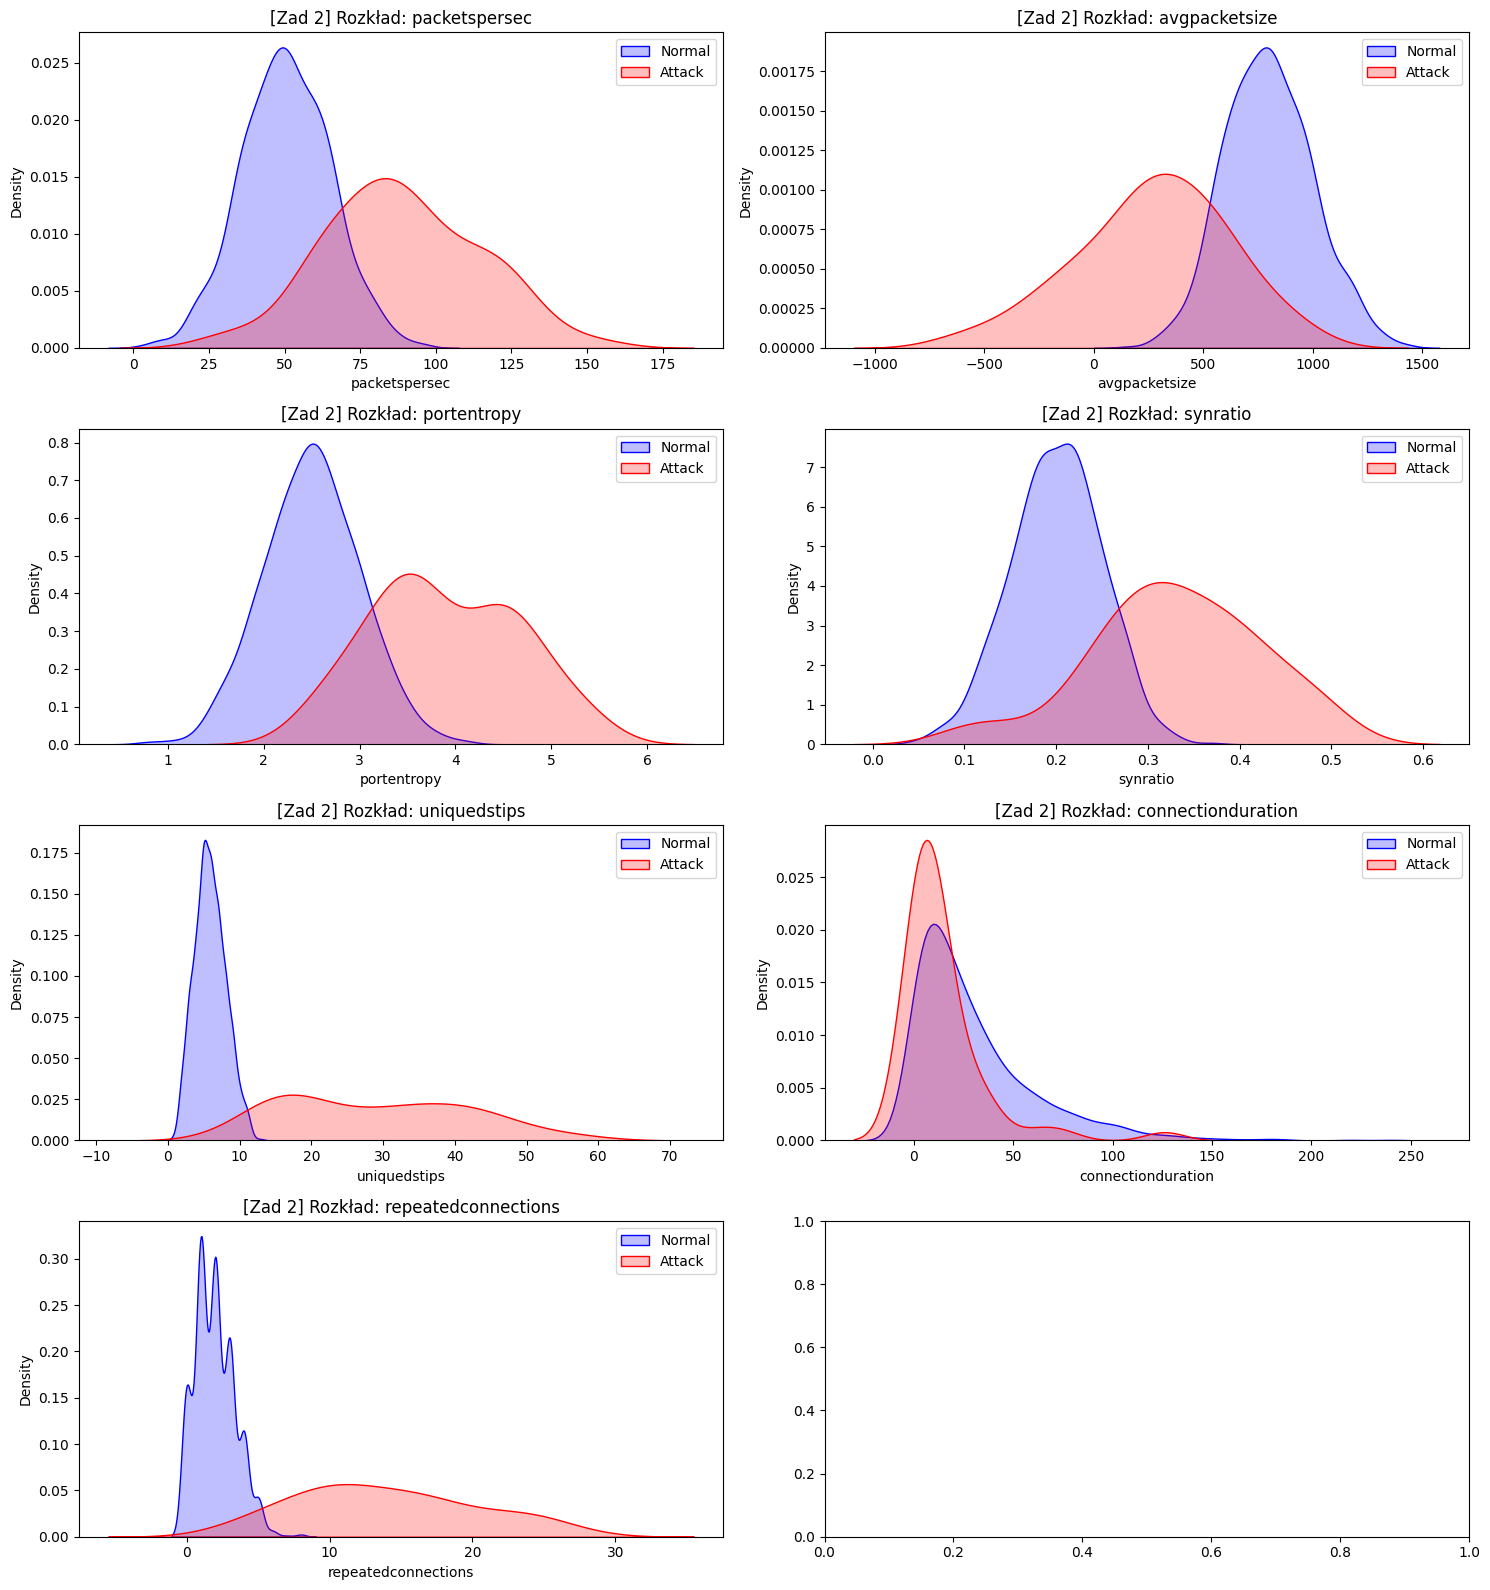

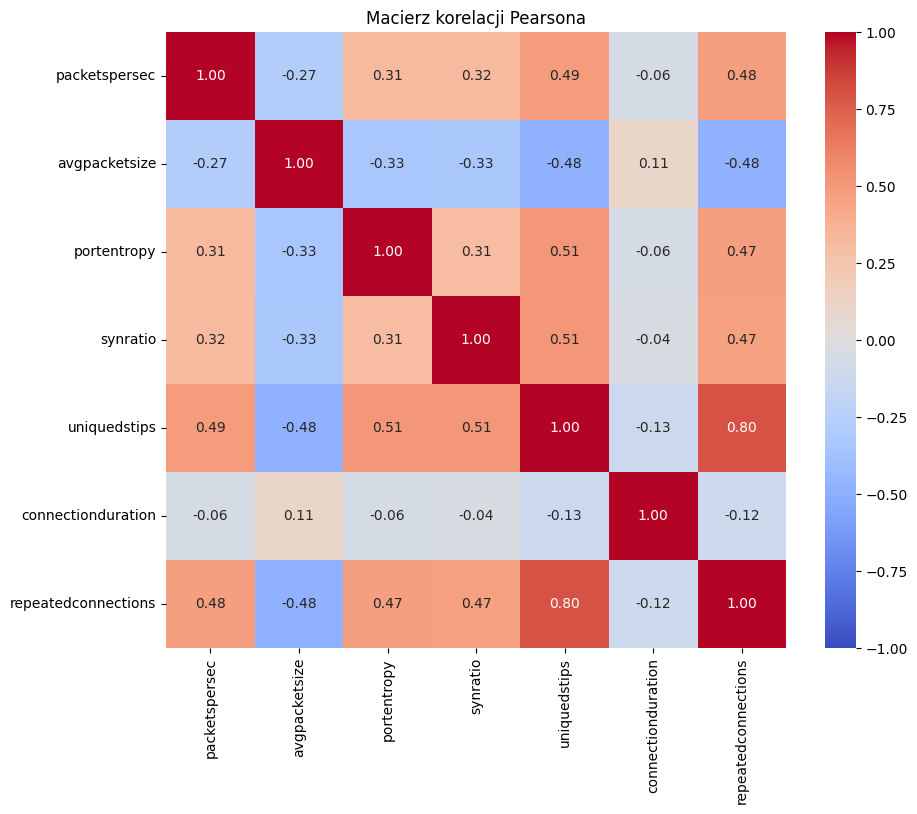

In [4]:
# Cell 4: Wizualizacja 
plot_distributions(df, feature_names, title_prefix='[Zad 2]')
plot_correlation_matrix(df, feature_names)

In [5]:
# Cell 5: Eksperyment - 3 Modele
# 1. Standard
print("Model Standard...")
model_std = train_model(X_train, y_train)
met_std, pred_std, prob_std = evaluate_model(model_std, X_test, y_test)

# 2. Balanced
print("Model Balanced...")
model_bal = train_model(X_train, y_train, class_weight='balanced')
met_bal, pred_bal, prob_bal = evaluate_model(model_bal, X_test, y_test)

# 3. Optimized Threshold (na modelu Standard)
print("Optymalizacja progu...")
tau_opt, costs, thresholds = optimize_threshold(model_std, X_test, y_test)
met_opt, pred_opt, _ = evaluate_model(model_std, X_test, y_test, threshold=tau_opt)

Model Standard...
Model Balanced...
Optymalizacja progu...


In [6]:
# Cell 6: Wyniki
print(f"Standard FN: {met_std['FN']}")
print(f"Balanced FN: {met_bal['FN']}")
print(f"Optimized FN: {met_opt['FN']} (Tau={tau_opt:.2f})")

Standard FN: 1
Balanced FN: 0
Optimized FN: 0 (Tau=0.12)


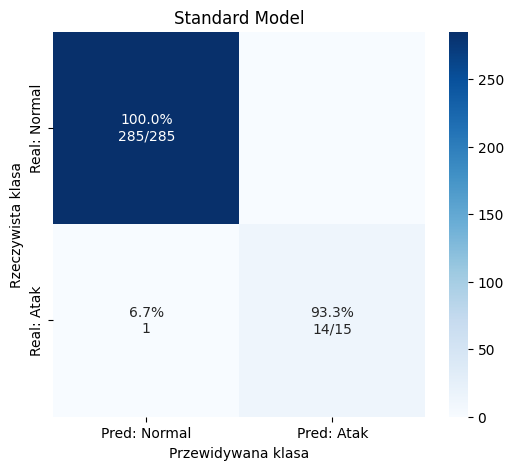

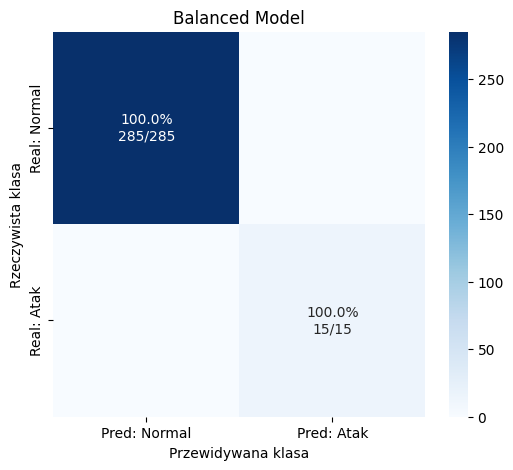

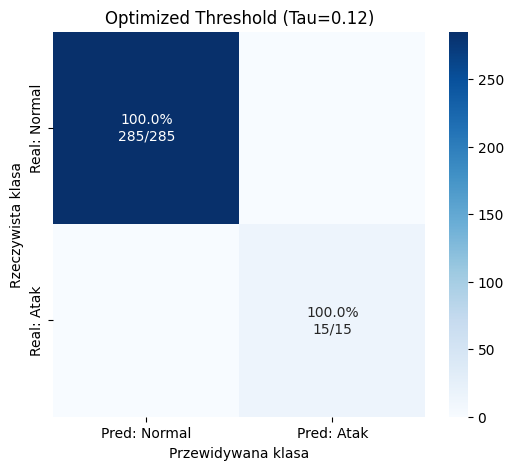

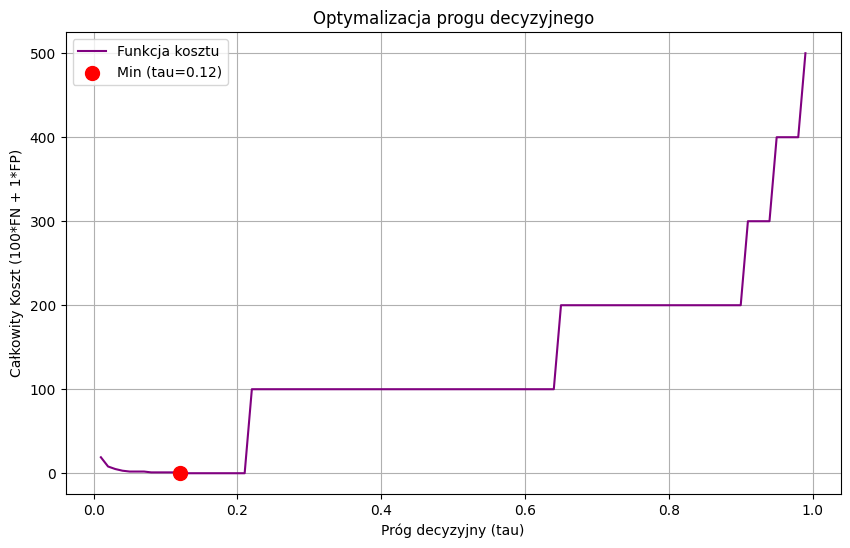

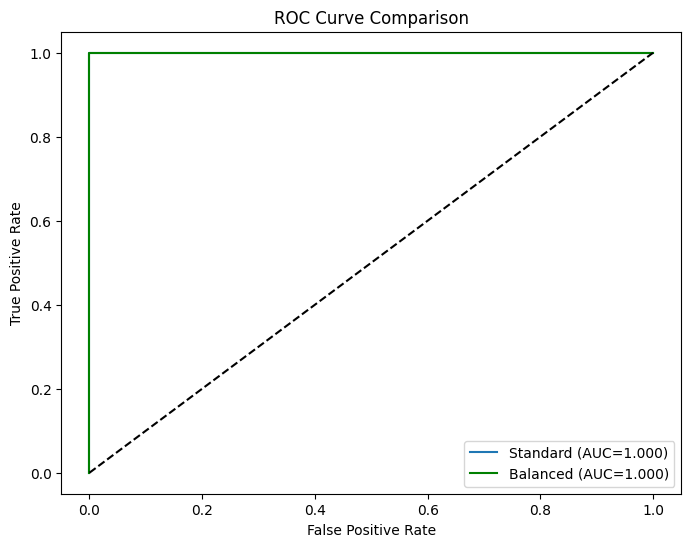

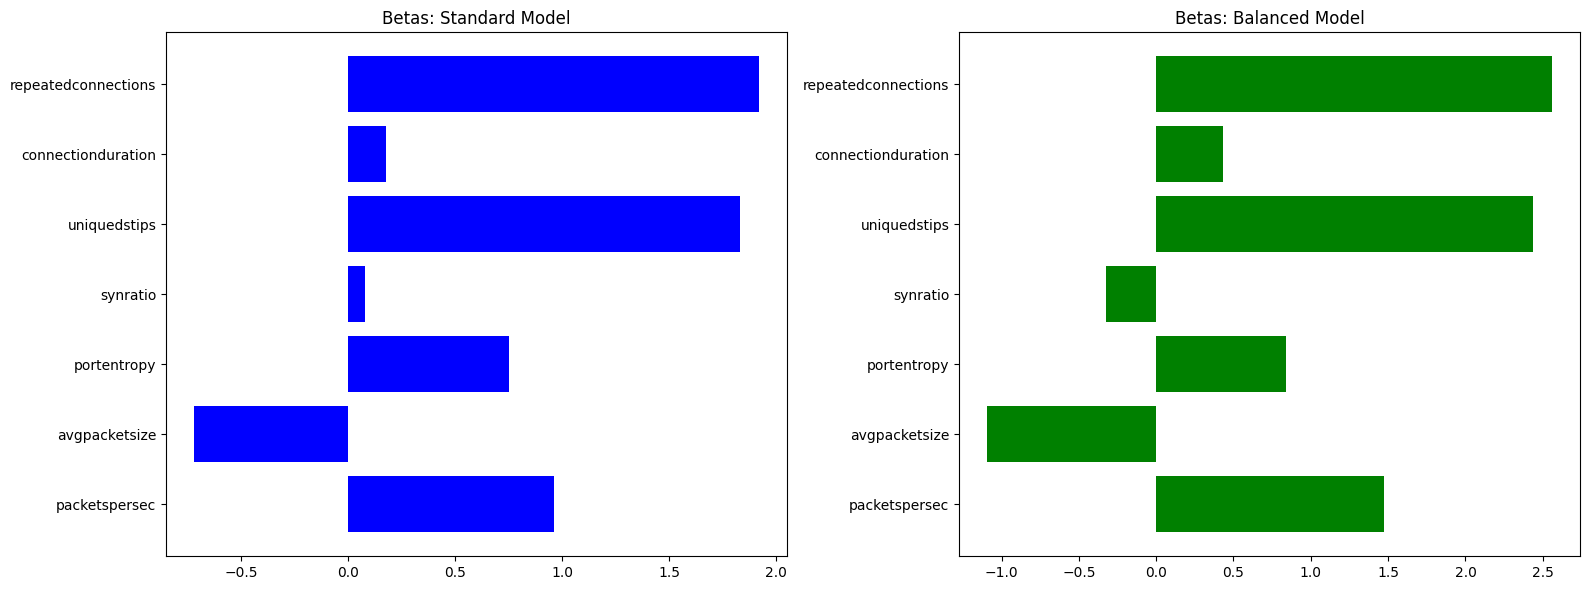


--- Analiza wpływu cech dla różnych typów ataków (Balanced Model) ---
Przykładowy wykryty atak (Index testowy: 10)


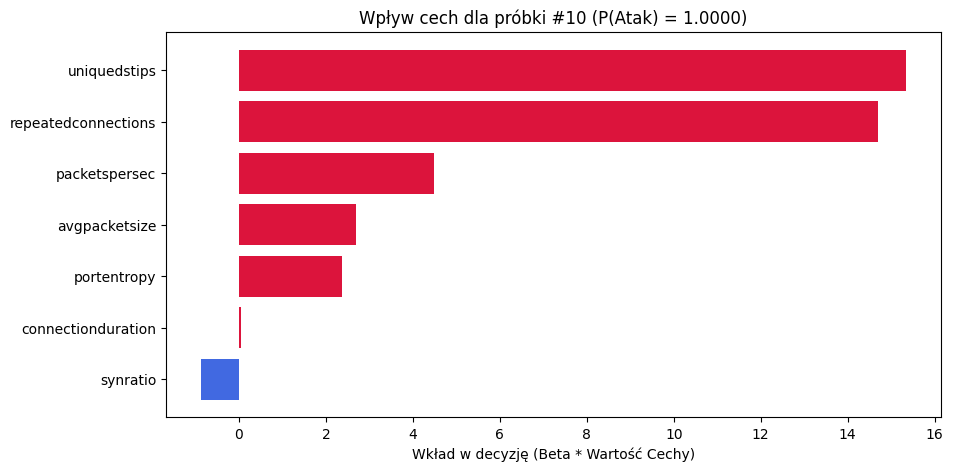

In [ ]:
# Cell 7: Wizualizacja
# 1. Macierze pomyłek
plot_confusion_matrix(y_test, pred_std, title='Standard Model')
plot_confusion_matrix(y_test, pred_bal, title='Balanced Model')
plot_confusion_matrix(y_test, pred_opt, title=f'Optimized Threshold (Tau={tau_opt:.2f})')

# 2. Koszt
plot_task2_cost(thresholds, costs, tau_opt, min(costs))

# 3. Krzywe ROC (Porównanie Standard vs Balanced na jednym wykresie)
plt.figure(figsize=(8, 6))
plt.plot(met_std['FPR'], met_std['TPR'], label=f"Standard (AUC={met_std['AUC']:.3f})")
plt.plot(met_bal['FPR'], met_bal['TPR'], label=f"Balanced (AUC={met_bal['AUC']:.3f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 4. Porównanie Betas (Współczynników)
# Rysujemy obok siebie, aby zobaczyć różnicę w wagach
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
beta_std = model_std.coef_[0]
beta_bal = model_bal.coef_[0]
idx = np.arange(len(feature_names))

ax[0].barh(feature_names, beta_std, color='blue')
ax[0].set_title("Betas: Standard Model")
ax[1].barh(feature_names, beta_bal, color='green')
ax[1].set_title("Betas: Balanced Model")
plt.tight_layout()
plt.show()

# 5. Analiza wpływu cech dla konkretnych typów ataków (Lokalna interpretowalność)
# Szukamy po jednej próbce z każdego rodzaju ataku w zbiorze testowym
print("\n--- Analiza wpływu cech dla różnych typów ataków (Balanced Model) ---")
# Musimy odzyskać typy ataków dla zbioru testowego

# Wybieramy losowe próbki sklasyfikowane jako atak przez model Balanced
attack_indices = np.where(pred_bal == 1)[0]
if len(attack_indices) > 0:
    chosen_idx = attack_indices[0] # Pierwszy z brzegu wykryty atak
    prob = prob_bal[chosen_idx]
    print(f"Przykładowy wykryty atak (Index testowy: {chosen_idx})")
    plot_feature_impact(model_bal, X_test, feature_names, sample_idx=chosen_idx, prediction_prob=prob)

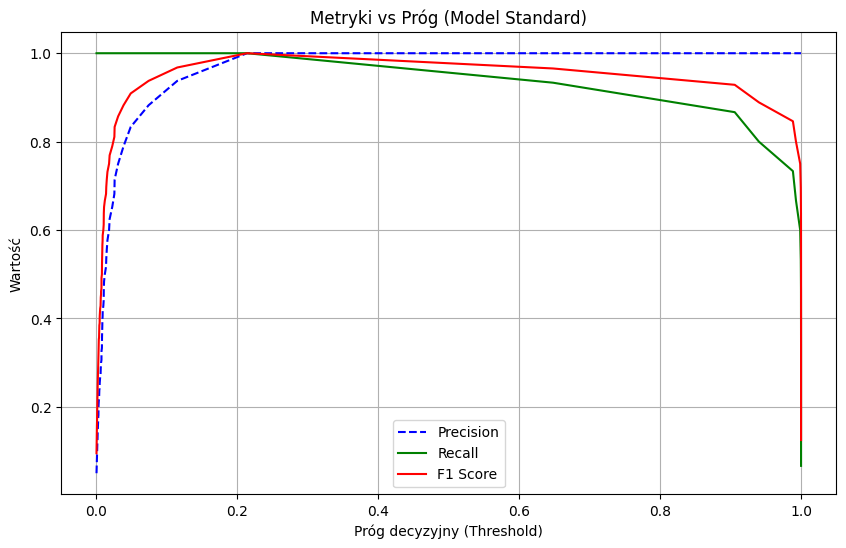

In [8]:
# Cell 8:  Wykres liniowy pokazujący jak Precision(τ), Recall(τ) i F1(τ) zmieniają się w funkcji progu
# Nie ma tego w src, więc robimy to tutaj bezpośrednio
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds_pr = precision_recall_curve(y_test, prob_std)
# F1 dla każdego progu
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds_pr, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds_pr, f1_scores[:-1], "r-", label="F1 Score")
plt.xlabel("Próg decyzyjny (Threshold)")
plt.ylabel("Wartość")
plt.title("Metryki vs Próg (Model Standard)")
plt.legend(loc="best")
plt.grid(True)
plt.show()